In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel

from scipy.integrate import quad
from scipy.interpolate import interp1d

from SyntheticDataModule import *
from estimators import *
from utils import *

RCT size: 500, OS size: 2000, time elapsed: 4.18


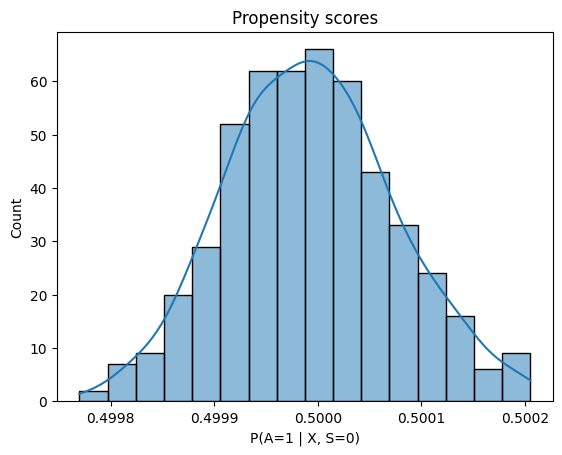

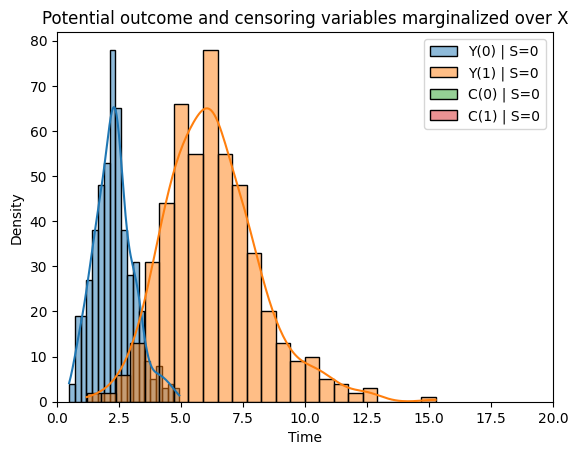

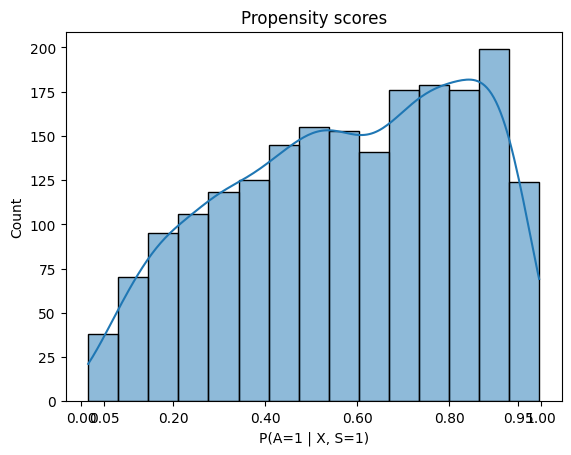

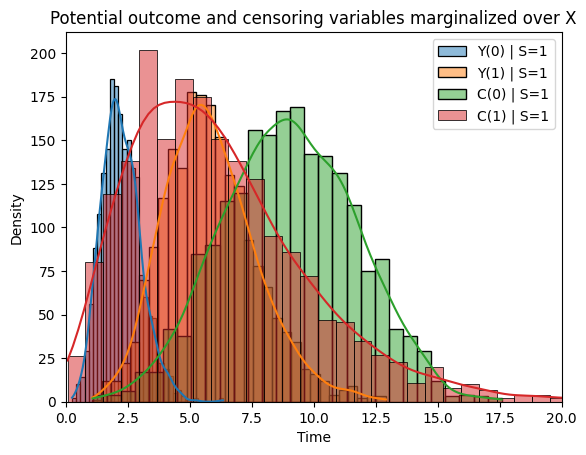

In [39]:
mmr_keys = ["IPW-Drop"]
CD = 10
UC = 0
jD = read_json('complete-IC/samePO.json', CD, UC, mmr_keys)
m = 4
os_size = int(jD['rct_size'] * m)

t1 = time()

df_combined, df_comb_drop, RCTData, OSData = generate_data(CD, os_size, jD)
Fb_Y, Gb_C = fill_nuisance(df_combined, df_comb_drop, jD)

print('RCT size: {}, OS size: {}, time elapsed: {:.2f}'.format(jD['rct_size'], os_size, time() - t1))

summary_df = pd.concat([RCTData.summary(plot=True), OSData.summary(plot=True)], axis=0, ignore_index=True)
summary_df

crop_prop = True

mmr_stats = np.zeros((len(mmr_keys), 2))  # store results and p-val for each mmr test

for kind, key in enumerate(mmr_keys):
    if 'Drop' in key:
        df_mmr = df_comb_drop.copy()
    else:
        df_mmr = df_combined.copy()

    if jD['crop_prop'] and ('Drop' not in key):
        df_mmr = df_mmr[(0.05 < df_mmr['P(S=1|X)']) & (df_mmr['P(S=1|X)'] < 0.95) &\
                (0.05 < df_mmr['P(A=1|X,S)']) & (df_mmr['P(A=1|X,S)'] < 0.95) &\
                (0.05 < df_mmr['Gb(T|X,S,A)'])].copy().reset_index(drop=True)

    if jD['crop_prop'] and ('Drop' in key):
        df_mmr = df_mmr[(0.05 < df_mmr['P(S=1|X)']) & (df_mmr['P(S=1|X)'] < 0.95) &\
                (0.05 < df_mmr['P(A=1|X,S)']) & (df_mmr['P(A=1|X,S)'] < 0.95)].copy().reset_index(drop=True)

    signal0, signal1 = jD['test_signals'][key][0], jD['test_signals'][key][1]
    mmr_stats[kind, 0], mmr_stats[kind, 1] = mmr_test(df_mmr, jD['cov_list'], jD['B'], laplacian_kernel, signal0, signal1)

In [40]:
mmr_stats

array([[0.        , 0.05940594]])

In [88]:
def eval_Qfunc_arr_v1(s, a, x, Gb_sa_t_idx, Fb_Y, thresh=1e-10):  
    '''
    Evaluate the Q function for all the "C" values in array Gb_sa_t_idx
    '''
    
    Fb_sa = Fb_Y[f'St_S{s}_A{a}']               # Fb(t|S=s,A=a) = P(Y>t|S=s,A=a) (baseline survival function for Y)
    Fb_sa_t = Fb_Y[f't_S{s}_A{a}']              # t indices for Fb(t|S=s,A=a)
    Fb_sa_beta = Fb_Y[f'beta_S{s}_A{a}']        # CoxPH param. estimates for Fb(t|X,S=s,A=a)
    Fb_sax = Fb_sa ** (np.exp(Fb_sa_beta @ x))  # Fb(t|X=x,S=s,A=a) = P(Y>t|X=x,S=s,A=a)
    
    Fb_denum = np.array(list(map(lambda c: eval_surv_(Fb_sa_t, Fb_sax, c), Gb_sa_t_idx)))
    thresh_indices = np.where(Fb_denum < thresh)[0]
        
    t_max = Fb_sa_t.max() # a proxy for the infinity upper bound on the integral
    t_int = np.append(Gb_sa_t_idx, t_max)
    
    func = interp1d(Fb_sa_t, Fb_sax, kind='linear', fill_value='extrapolate')  # Fb(t|X=x,S=s,A=a)
    
    
    # Calculate individual areas of Integral(Fb(t|..)) between every value in Gb_sa_t_idx and finally to infinity (tmax)
    interval_integrals = np.array(list(map(lambda c1, c2: quad(func, a=c1, b=c2, limit=1)[0], t_int[:-1], t_int[1:])))
    #interval_integrals = np.array(list(map(lambda c1, c2: (c2 - c1) * (func(c2) + func(c1)) / 2, t_int[:-1], t_int[1:])))
    
    # Three lines below compute "integrals" which is equal to Fb(c|..) for every c in Gb_sa_t_idx
    shift_cumsum = np.roll(np.cumsum(interval_integrals), 1)
    shift_cumsum[0] = 0  
    Fb_num = np.sum(interval_integrals) - shift_cumsum
    
    fin_val = (Fb_num / Fb_denum) + Gb_sa_t_idx
    
#     if len(thresh_indices) > 0:
#         fin_val[thresh_indices[-1] - 1:] = Gb_sa_t_idx[thresh_indices[-1] - 1:]    

    return fin_val, interval_integrals, Fb_num, Fb_denum


def eval_Qfunc_arr_v2(s, a, x, Gb_sa_t_idx, Fb_Y, thresh=1e-10):  
    '''
    Evaluate the Q function for all the "C" values in array Gb_sa_t_idx
    '''
    
    Fb_sa = Fb_Y[f'St_S{s}_A{a}']               # Fb(t|S=s,A=a) = P(Y>t|S=s,A=a) (baseline survival function for Y)
    Fb_sa_t = Fb_Y[f't_S{s}_A{a}']              # t indices for Fb(t|S=s,A=a)
    Fb_sa_beta = Fb_Y[f'beta_S{s}_A{a}']        # CoxPH param. estimates for Fb(t|X,S=s,A=a)
    Fb_sax = Fb_sa ** (np.exp(Fb_sa_beta @ x))  # Fb(t|X=x,S=s,A=a) = P(Y>t|X=x,S=s,A=a)
    
    Fb_denum = np.array(list(map(lambda c: eval_surv_(Fb_sa_t, Fb_sax, c), Gb_sa_t_idx)))
    thresh_indices = np.where(Fb_denum < thresh)[0]
        
    t_max = Fb_sa_t.max() # a proxy for the infinity upper bound on the integral
    t_int = np.append(Gb_sa_t_idx, t_max)
    
    func = interp1d(Fb_sa_t, Fb_sax, kind='linear', fill_value='extrapolate')  # Fb(t|X=x,S=s,A=a)
    
    
    # Calculate individual areas of Integral(Fb(t|..)) between every value in Gb_sa_t_idx and finally to infinity (tmax)
    #interval_integrals = np.array(list(map(lambda c1, c2: quad(func, a=c1, b=c2, limit=1)[0], t_int[:-1], t_int[1:])))
    interval_integrals = np.array(list(map(lambda c1, c2: (c2 - c1) * (func(c2) + func(c1)) / 2, t_int[:-1], t_int[1:])))
    #interval_integrals[-1] = quad(func, a=t_int[-2], b=t_int[-1], limit=1)[0]
    
    # Three lines below compute "integrals" which is equal to Fb(c|..) for every c in Gb_sa_t_idx
    shift_cumsum = np.roll(np.cumsum(interval_integrals), 1)
    shift_cumsum[0] = 0  
    Fb_num = np.sum(interval_integrals) - shift_cumsum
    
    fin_val = (Fb_num / Fb_denum) + Gb_sa_t_idx
    
#     if len(thresh_indices) > 0:
#         fin_val[thresh_indices[-1] - 1:] = Gb_sa_t_idx[thresh_indices[-1] - 1:]
    
    return fin_val, interval_integrals, Fb_num, Fb_denum

In [92]:
np.random.randn()

0.6557695111969162

Time: 0.00197 s.
Result of integration: 2.2859939295368465, error: 2.3074743508300743


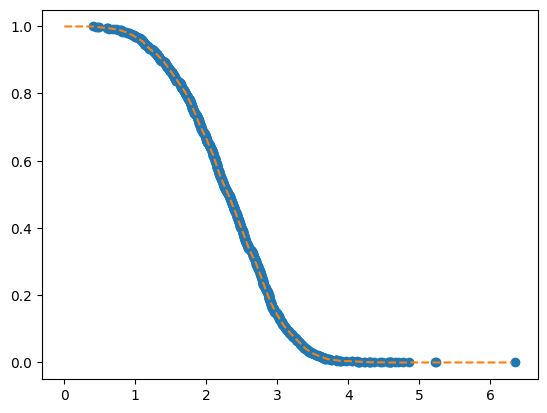

Time: 0.0032052993774414062


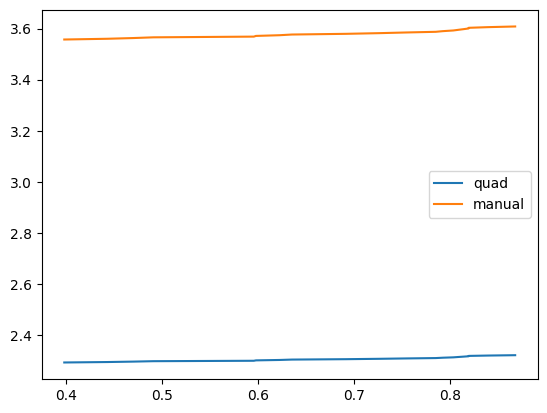

In [89]:
s, a = 1,0
x = np.zeros(CD + 1)
ty, sty = Fb_Y[f't_S{s}_A{a}'], Fb_Y[f'St_S{s}_A{a}']
tc, stc = Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}']

t_arr = ty #
st_arr = sty  

func = interp1d(t_arr, st_arr, kind='nearest', fill_value='extrapolate')
t1 = time()
result, error = quad(func, 0, t_arr.max(), limit=1)
print(f"Time: {time()-t1:.5f} s.")
print(f"Result of integration: {result}, error: {error}")

xnew = np.arange(0, t_arr.max(), 0.1)
ynew = func(xnew)   # use interpolation function returned by `interp1d`
plt.plot(t_arr, st_arr, 'o', xnew, ynew, '--')
plt.show()

Trange = tc[:20].copy()
q_arr_batch_v1, interval_integrals_v1, Fb_num_v1, Fb_denum_v1 = eval_Qfunc_arr_v1(s, a, x, Trange, Fb_Y)
t1 = time()
q_arr_batch_v2, interval_integrals_v2, Fb_num_v2, Fb_denum_v2 = eval_Qfunc_arr_v2(s, a, x, Trange, Fb_Y)
print(f"Time: {time() - t1}")
plt.figure()
plt.plot(Trange, q_arr_batch_v1, label='quad')
plt.plot(Trange, q_arr_batch_v2, label='manual')
plt.legend()
plt.show()

In [85]:
Trange

array([0.39864719, 0.4431447 , 0.47023915, 0.49127924, 0.59569138,
       0.59791936, 0.62236923, 0.63527742, 0.69119941, 0.72601459,
       0.75389332, 0.78482639, 0.79226788, 0.80311943, 0.80834777,
       0.81384125, 0.81892149, 0.81902231, 0.8392277 , 0.86738084])

In [77]:
Fb_num_v1

array([1.89301348, 1.84857685, 1.82154419, 1.80057129, 1.69658806,
       1.69437127, 1.67006666, 1.657247  , 1.60175989, 1.56724745,
       1.5396368 , 1.50902965, 1.50167341, 1.49095619, 1.4857974 ,
       1.48038205, 1.47537876, 1.47527956, 1.45541751, 1.42776882])

In [78]:
Fb_num_v2

array([3.15547264, 3.11103601, 3.08400335, 3.06303045, 2.95904722,
       2.95683043, 2.93252582, 2.91970616, 2.86421905, 2.82970661,
       2.80209596, 2.77148881, 2.76413257, 2.75341535, 2.74825656,
       2.74284121, 2.73783792, 2.73773872, 2.71787666, 2.69022798])

In [81]:
interval_integrals_v1

array([4.44366338e-02, 2.70326555e-02, 2.09729050e-02, 1.03983225e-01,
       2.21678994e-03, 2.43046116e-02, 1.28196612e-02, 5.54871109e-02,
       3.45124387e-02, 2.76106536e-02, 3.06071521e-02, 7.35623298e-03,
       1.07172185e-02, 5.15879519e-03, 5.41534888e-03, 5.00328988e-03,
       9.92037799e-05, 1.98620520e-02, 2.76486809e-02, 1.42776882e+00])

In [82]:
interval_integrals_v2

array([4.44366338e-02, 2.70326555e-02, 2.09729050e-02, 1.03983225e-01,
       2.21678994e-03, 2.43046116e-02, 1.28196612e-02, 5.54871109e-02,
       3.45124387e-02, 2.76106536e-02, 3.06071521e-02, 7.35623298e-03,
       1.07172185e-02, 5.15879519e-03, 5.41534888e-03, 5.00328988e-03,
       9.92037799e-05, 1.98620520e-02, 2.76486809e-02, 2.69022798e+00])

In [69]:
len(tc)

867

In [37]:
sty

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 9.98809418e-01, 9.97619099e-01,
       9.97619099e-01, 9.97619099e-01, 9.97619099e-01, 9.97619099e-01,
       9.97619099e-01, 9.97619099e-01, 9.97619099e-01, 9.97619099e-01,
       9.97619099e-01, 9.97619099e-01, 9.97619099e-01, 9.97619099e-01,
       9.97619099e-01, 9.97619099e-01, 9.97619099e-01, 9.97619099e-01,
       9.97619099e-01, 9.97619099e-01, 9.97619099e-01, 9.97619099e-01,
       9.97619099e-01, 9.97619099e-01, 9.97619099e-01, 9.97619099e-01,
       9.97619099e-01, 9.97619099e-01, 9.97619099e-01, 9.97619099e-01,
       9.97619099e-01, 9.97619099e-01, 9.97619099e-01, 9.97619099e-01,
       9.97619099e-01, 9.97619099e-01, 9.97619099e-01, 9.97619099e-01,
      

In [15]:
interval_integrals

array([1.17472653e-01, 1.17382518e-01, 1.17292383e-01, 1.17205817e-01,
       1.17093363e-01, 1.16892664e-01, 1.16609098e-01, 1.16152202e-01,
       1.15296822e-01, 1.13263392e-01, 1.11269204e-01, 1.08770111e-01,
       1.05613168e-01, 1.00848369e-01, 9.65792423e-02, 8.95822895e-02,
       8.13537964e-02, 7.41248734e-02, 6.64338656e-02, 5.72812546e-02,
       4.83231996e-02, 4.15737862e-02, 3.54450951e-02, 3.01297158e-02,
       2.28717519e-02, 1.62305189e-02, 1.33855187e-02, 9.84152630e-03,
       6.93504976e-03, 4.15669328e-03, 2.42268325e-03, 1.50745488e-03,
       9.10525209e-04, 7.06750078e-04, 4.14800477e-04, 1.61051001e-04,
       5.50051099e-05, 5.96837106e-06, 3.25923463e-06, 2.17234310e-06,
       8.11136438e-07, 1.09050806e-07, 2.53928469e-08, 3.25052352e-09,
       3.25052352e-09, 3.25052352e-09, 3.14171304e-09, 2.33381732e-09,
       1.40128586e-09, 4.68754399e-10, 0.00000000e+00])

In [16]:
Fb_denum

array([9.99054668e-01, 9.99054668e-01, 9.98993257e-01, 9.98225858e-01,
       9.97530619e-01, 9.95931987e-01, 9.94288471e-01, 9.91506883e-01,
       9.86335144e-01, 9.72015883e-01, 9.54696365e-01, 9.36236786e-01,
       9.14715646e-01, 8.79850295e-01, 8.40151518e-01, 7.96260182e-01,
       7.22991522e-01, 6.63185306e-01, 5.99877379e-01, 5.26198760e-01,
       4.49631719e-01, 3.78205459e-01, 3.22593862e-01, 2.81651737e-01,
       2.28466877e-01, 1.58173676e-01, 1.26441069e-01, 9.72815752e-02,
       7.23125345e-02, 4.41148200e-02, 2.68361130e-02, 1.65954041e-02,
       9.78363233e-03, 6.44056516e-03, 4.63440241e-03, 2.21168283e-03,
       8.58446977e-04, 7.62428543e-05, 3.17257883e-05, 2.37714702e-05,
       1.22007224e-05, 1.58169911e-06, 4.68984767e-07, 2.76744643e-08,
       2.76744643e-08, 2.76744643e-08, 2.76744643e-08, 2.38394824e-08,
       1.59000510e-08, 7.96061957e-09, 2.11881376e-11])

In [ ]:
a = np.array([1,2,3])

In [ ]:
np.append(a,1)

In [ ]:
a

In [ ]:
Fb_num

In [ ]:
Fb_denum

In [ ]:
interval_integrals

In [ ]:
dfdf = df_mmr[df_mmr['Gb(T|X,S,A)'] > 0.1].copy()

In [ ]:
q_arr_batch

In [ ]:
interval_integrals

In [ ]:
mmr_stats = np.zeros((len(mmr_keys), 2))  # store results and p-val for each mmr test
mmr_keys = ["CDR", "IPCW", "IPW-Impute"]
for kind, key in enumerate(mmr_keys):
    signal0, signal1 = jD['test_signals'][key][0], jD['test_signals'][key][1]
    mmr_stats[kind, 0], mmr_stats[kind, 1] = mmr_test(dfdf, jD['cov_list'], jD['B'], laplacian_kernel, signal0, signal1)

In [ ]:
mmr_stats

In [ ]:
len(df_mmr)

In [ ]:
df_combined['Gb(T|X,S,A)'].sort_values()

In [ ]:
row = 2088

s = df_combined.loc[row, 'S']
a = df_combined.loc[row, 'A']
x = np.array(df_combined.loc[row, jD['cov_list']])
T = df_combined.loc[row, 'T']
Delta = df_combined.loc[row, 'Delta']

df_combined.loc[row]

In [ ]:
df_mmr['P(S=1|X)'].sort_values()

In [ ]:
print('CDR-S0-ATE: {:.2f}\n'.format(df_mmr['S0_cdr_est_CATE'].mean()))
print('CDR-S1-ATE: {:.2f}\n'.format(df_mmr['S1_cdr_est_CATE'].mean()))

print('IPCW-S0-Y0: {:.2f}'.format(df_mmr['S0_ipcw_est_Y0'].mean()))
print('IPCW-S0-Y1: {:.2f}'.format(df_mmr['S0_ipcw_est_Y1'].mean()))
print('IPCW-S0-ATE: {:.2f}\n'.format(df_mmr['S0_ipcw_est_CATE'].mean()))

print('IPCW-S1-Y0: {:.2f}'.format(df_mmr['S1_ipcw_est_Y0'].mean()))
print('IPCW-S1-Y1: {:.2f}'.format(df_mmr['S1_ipcw_est_Y1'].mean()))
print('IPCW-S1-ATE: {:.2f}\n'.format(df_mmr['S1_ipcw_est_CATE'].mean()))

print('IPW-Impute-S0-Y0: {:.2f}'.format(df_mmr['S0_impute_ipw_est_Y0'].mean()))
print('IPW-Impute-S0-Y1: {:.2f}'.format(df_mmr['S0_impute_ipw_est_Y1'].mean()))
print('IPW-Impute-S0-ATE: {:.2f}\n'.format(df_mmr['S0_impute_ipw_est_CATE'].mean()))

print('IPW-Impute-S1-Y0: {:.2f}'.format(df_mmr['S1_impute_ipw_est_Y0'].mean()))
print('IPW-Impute-S1-Y1: {:.2f}'.format(df_mmr['S1_impute_ipw_est_Y1'].mean()))
print('IPW-Impute-S1-ATE: {:.2f}\n'.format(df_mmr['S1_impute_ipw_est_CATE'].mean()))

print('IPW-Drop-S0-Y0: {:.2f}'.format(df_comb_drop['S0_drop_ipw_est_Y0'].mean()))
print('IPW-Drop-S0-Y1: {:.2f}'.format(df_comb_drop['S0_drop_ipw_est_Y1'].mean()))
print('IPW-Drop-S0-ATE: {:.2f}\n'.format(df_comb_drop['S0_drop_ipw_est_CATE'].mean()))

print('IPW-Drop-S1-Y0: {:.2f}'.format(df_comb_drop['S1_drop_ipw_est_Y0'].mean()))
print('IPW-Drop-S1-Y1: {:.2f}'.format(df_comb_drop['S1_drop_ipw_est_Y1'].mean()))
print('IPW-Drop-S1-ATE: {:.2f}'.format(df_comb_drop['S1_drop_ipw_est_CATE'].mean()))

summary_df

In [ ]:
row = 1002

s = df_mmr.loc[row, 'S']
a = df_mmr.loc[row, 'A']
x = np.array(df_combined.loc[row, jD['cov_list']])
T = df_mmr.loc[row, 'T']
Delta = df_mmr.loc[row, 'Delta']

df_mmr.loc[row]

In [ ]:
eval_surv_(Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}'], T)

In [ ]:
eval_int_term_(s, a, x, T, Gb_C, Fb_Y)

In [ ]:
eval_Ystar_(s, a, x, Delta, T, Gb_C, Fb_Y)

In [ ]:
eval_Qfunc_(s, a, x, T, Fb_Y, thresh=1e-6)

In [ ]:
df_mmr['S1_cdr_est_CATE'].sort_values()

In [ ]:
df_mmr['Gb(T|X,S,A)'].sort_values()

In [ ]:
df_mmr = df_mmr[]

In [ ]:
s, a = 0, 0
ty, sty = Fb_Y[f't_S{s}_A{a}'], Fb_Y[f'St_S{s}_A{a}']
tc, stc = Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}']

t_arr = tc #
st_arr = stc  

t1 = time()
func = interp1d(t_arr, st_arr, kind='nearest', fill_value='extrapolate')
result, error = quad(func, 0, t_arr.max() + 10, limit=5)

print(f"Time: {time()-t1:.2f} s.")
print(f"Result of integration: {result}, error: {error}")

xnew = np.arange(0, t_arr.max() + 10, 0.1)
ynew = func(xnew)   # use interpolation function returned by `interp1d`
plt.plot(t_arr, st_arr, 'o', xnew, ynew, '--')
plt.show()

In [ ]:
func(12)

In [ ]:
q_arr_batch

In [ ]:
interval_integrals

In [ ]:
Fb_num

In [ ]:
Fb_num

In [ ]:
h_arr

In [ ]:
ty.max()

In [ ]:
t_arr.max()

In [ ]:
pv = np.load('results/complete-IC/samePO/CD-10/UC-0/pvals.npy')
csv = pd.read_csv('results/complete-IC/samePO/CD-10/UC-0/res_summary.csv')

In [ ]:
pv

In [ ]:
np.mean(pv[2], axis=1)

In [ ]:
csv

In [ ]:
a = [0,1,2,3]

In [ ]:
a[:-1]

In [ ]:
pv.shape

In [ ]:
x_space = np.linspace(-10,10,401)
cov_name = 'X1'
os_oracle_prop = OSData.calc_oracle_prop(x_space, cov_name)
plt.figure()
plt.plot(x_space, os_oracle_prop)
plt.xlabel(cov_name)
plt.ylabel(f'P(A=1|{cov_name},S=1)')
plt.title(f'Oracle propensity score in study S=1 wrt covariate {cov_name}')
plt.show()

t = np.linspace(0,20,101)
cov_vals = [0, 0, 0, 0]
tbs_Y0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y0')
tbs_Y1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y1')
tbs_C0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C0')
tbs_C1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C1')
plt.figure()
plt.plot(t, tbs_Y0, label='Y0', alpha= 0.4, ls ='--')
plt.plot(t, tbs_Y1, label='Y1', alpha= 1, ls ='-.')
plt.plot(t, tbs_C0, label='C0', alpha= 0.4)
plt.plot(t, tbs_C1, label='C1', alpha= 0.4)
plt.xlabel('t')
plt.ylabel(r'$S(t)$')
plt.title(f'True survival curves in study S=0 with X={cov_vals}')
plt.legend()
plt.show()